In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from edward.models import Normal, Categorical, Uniform, Empirical, TransformedDistribution
import tensorflow as tf
import edward as ed


In [2]:
# data generation
K_true = np.array([[ 0.,  0.,  0.75312,  0.,  0., 0.],
                   [ 0.,  0.15979,  0.,  0.,  0.,-0.13297],
                   [ 0.,  0.,  0.92048,  0.,  0., 0.]])
phis_np = np.load('phis.npy')

In [3]:
# Data to fit to
data = (phis_np.dot(K_true)).trace(axis1=1, axis2=2)
rel_data = data - min(data)

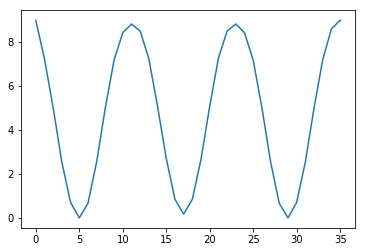

In [4]:
plt.plot(rel_data);

In [5]:
phis_ts = tf.constant(phis_np, dtype=tf.float32)
data_ts = tf.constant(rel_data, dtype=tf.float32)

In [6]:
# Set up Edward model
T = 10000
ds = tf.contrib.distributions

# Latent variables
K = Normal(loc=tf.zeros((6,3)), scale=1.0)
log_sigma = Uniform(low=[-4.6052], high=[3.453])
sigma = TransformedDistribution(distribution=log_sigma, bijector=ds.bijectors.Exp(), name='sigma')

# Proposal variables
proposal_sigma = Normal(loc=sigma, scale=0.02)
proposal_K = Normal(loc=K, scale=0.02)

# Empirical variables
qK = Empirical(tf.Variable(tf.zeros([T, 6, 3])))
qsigma = Empirical(tf.Variable(tf.zeros([T, 1])))

# Observed
Fourier_sum = tf.reduce_sum(tf.reduce_sum(tf.multiply(phis_ts, K), axis=1), axis=1)
Fourier_sum_rel = Fourier_sum - tf.reduce_min(Fourier_sum)

# Likelihood
likelihood = Normal(loc=Fourier_sum_rel, scale=1.0)

# Inference
inference = ed.MetropolisHastings(latent_vars={K: qK}, 
                                  proposal_vars={K: proposal_K}, 
                                  data={likelihood: data_ts})

In [7]:
inference.run()

10000/10000 [100%] ██████████████████████████████ Elapsed: 14s | Acceptance Rate: 0.586


In [8]:
# Results
K_traces = inference.latent_vars[K]

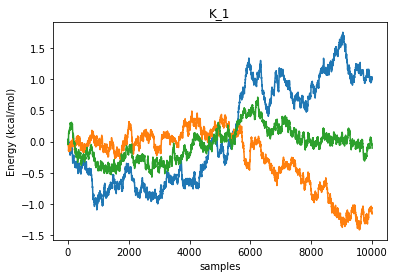

In [9]:
plt.plot(K_traces.get_variables()[0].eval()[:,0]);
plt.title('K_1')
plt.xlabel('samples')
plt.ylabel('Energy (kcal/mol)');

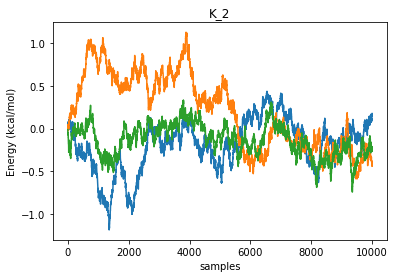

In [10]:
plt.plot(K_traces.get_variables()[0].eval()[:,1]);
plt.title('K_2')
plt.xlabel('samples')
plt.ylabel('Energy (kcal/mol)');

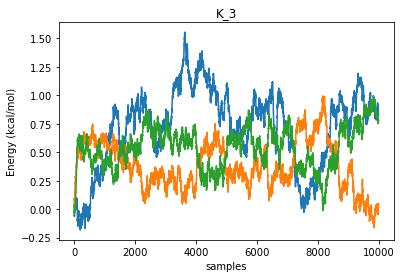

In [11]:
plt.plot(K_traces.get_variables()[0].eval()[:,2]);
plt.title('K_3')
plt.xlabel('samples')
plt.ylabel('Energy (kcal/mol)');

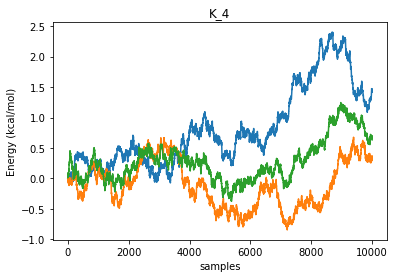

In [12]:
plt.plot(K_traces.get_variables()[0].eval()[:,3]);
plt.title('K_4')
plt.xlabel('samples')
plt.ylabel('Energy (kcal/mol)');

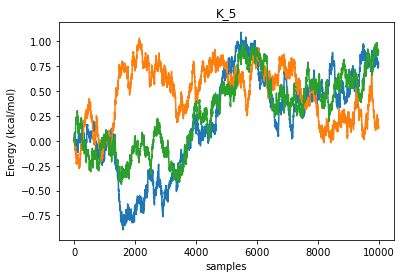

In [13]:
plt.plot(K_traces.get_variables()[0].eval()[:,4]);
plt.title('K_5')
plt.xlabel('samples')
plt.ylabel('Energy (kcal/mol)');

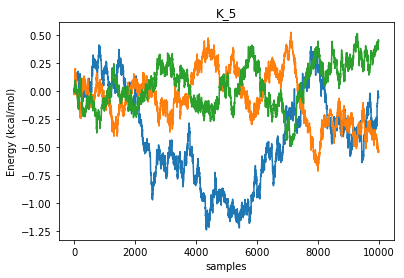

In [14]:
plt.plot(K_traces.get_variables()[0].eval()[:,5]);
plt.title('K_5')
plt.xlabel('samples')
plt.ylabel('Energy (kcal/mol)');

In [15]:
def observed_eval(trace):
    energy_trace = np.zeros([len(trace), 36])
    for i in range(len(trace)):
        fourier_sum = (trace[i][np.newaxis, :,:]*phis_np).sum(1).sum(1)
        energy_trace[i] = fourier_sum - min(fourier_sum)
    return energy_trace

In [16]:
traces = inference.latent_vars[K].get_variables()[0].eval()
energy = observed_eval(traces)

In [17]:
import seaborn as sns

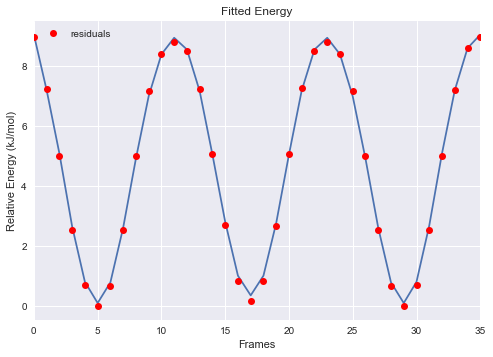

In [18]:
sns.tsplot(energy[1000:])
plt.plot(rel_data, 'o', color='red', label='residuals')
plt.title('Fitted Energy')
plt.xlabel('Frames')
plt.ylabel('Relative Energy (kJ/mol)')
plt.legend();

In [19]:
# Include Jeffrey Prios on sigma
# Inference
inference_2 = ed.MetropolisHastings(latent_vars={K: qK, sigma: qsigma}, 
                                  proposal_vars={K: proposal_K, sigma: proposal_sigma}, 
                                  data={likelihood: data_ts})
inference_2.run()

10000/10000 [100%] ██████████████████████████████ Elapsed: 18s | Acceptance Rate: 0.000
